# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
impt_data = pd.read_csv("CLC_train.csv")
test_data = pd.read_csv("CLC_test.csv")

In [3]:
labels_pd = impt_data.pop("CO_level")
labels_test_pd = test_data.pop("CO_level")

In [4]:
impt_data.columns

Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH'],
      dtype='object')

In [5]:
# exclude_columns = ['Date', 'Time', 'NMHC_GT', 'C6H6_GT'
#        , 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2',
#        'PT08_S5_O3', 'T', 'RH', 'AH']
include_columns = ["CO_GT", "PT08_S1_CO", "PT08_S2_NMHC"]
# exclude_columns = ["Date", "Time", "CO_GT", "NMHC_GT", "T", "RH", "AH"]
# data_pd = impt_data.drop(exclude_columns, axis = 1)
data_pd = impt_data[include_columns]
# data_test_pd = test_data.drop(exclude_columns, axis = 1)
data_test_pd = test_data[include_columns]

In [6]:
data = data_pd.to_numpy()
labels = labels_pd.to_numpy()
X_test = data_test_pd.to_numpy()
Y_test = labels_test_pd.to_numpy()
print(data.shape)
print(X_test.shape)

(7485, 3)
(1872, 3)


# Cleaning the data

In [7]:
remove_rows = impt_data[impt_data['AH'] == -200].index.to_numpy()
data = np.delete(data, tuple(remove_rows), axis = 0)
labels = np.delete(labels, tuple(remove_rows), axis = 0)

In [8]:
# remove_rows = test_data[test_data['AH'] == -200].index.to_numpy()
# # print(data_test_pd.shape)
# X_test = np.delete(X_test, tuple(remove_rows), axis = 0)
# print(X_test.shape)
# Y_test = np.delete(Y_test, tuple(remove_rows), axis = 0)

In [9]:
labels.shape

(7162,)

# Train Test Split

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0, test_size = 0.4)

In [11]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.transform(np.expand_dims(Y_val, 1)).toarray()
Y_OH_test = enc.transform(np.expand_dims(Y_test, 1)).toarray()

In [12]:
X_train, Y_OH_train, X_val, Y_OH_val, X_test, Y_OH_test = map(torch.tensor, (X_train, Y_OH_train, X_val, Y_OH_val, X_test, Y_OH_test))

In [13]:
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()

In [14]:
impt_data

,Date,Time,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,Nox_GT,PT08_S3_Nox,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,11/23/2004,19:00:00,11.9,2008,-200,50.6,1980,1389,325,220,2562,2342,12.4,74.7,1.0741
1,11/23/2004,20:00:00,11.5,1918,-200,49.4,1958,1358,335,190,2477,2237,11.5,76.2,1.0324
2,11/17/2004,18:00:00,10.2,1802,-200,47.7,1924,748,356,192,2235,2452,13.7,52.8,0.8244
3,11/23/2004,18:00:00,10.2,1982,-200,49.5,1959,1369,322,227,2536,2386,13.2,72.6,1.0936
4,11/26/2004,18:00:00,10.1,1956,-200,45.2,1877,1389,347,255,2338,2465,15.5,62.8,1.0979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7480,10/17/2004,1:00:00,-200.0,864,-200,2.7,633,-200,1097,-200,1259,523,16.4,70.3,1.3031
7481,10/17/2004,2:00:00,-200.0,929,-200,3.8,698,-200,991,-200,1307,610,15.4,78.1,1.3557
7482,10/17/2004,3:00:00,-200.0,912,-200,3.6,690,-200,984,-200,1309,574,15.8,75.5,1.3436
7483,10/17/2004,4:00:00,-200.0,817,-200,2.2,602,-200,1120,-200,1227,470,16.0,69.5,1.2549


In [15]:
test_data

,Date,Time,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,Nox_GT,PT08_S3_Nox,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,11/2/2004,20:00:00,9.2,1778,-200,48.2,1935,859,349,119,2643,1927,20.9,67.5,1.6539
1,12/16/2004,20:00:00,9.1,-200,-200,-200.0,-200,1253,-200,219,-200,-200,-200.0,-200.0,-200.0000
2,12/23/2004,20:00:00,9.1,1701,-200,36.3,1692,1220,402,252,1832,2415,6.2,56.9,0.5419
3,11/1/2004,8:00:00,1.5,1067,-200,8.7,928,213,711,51,1564,1309,19.1,75.6,1.6519
4,11/1/2004,14:00:00,1.5,1082,-200,6.5,834,174,747,64,1562,991,23.1,70.8,1.9800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,3/23/2005,4:00:00,-200.0,993,-200,2.3,604,85,848,65,1160,762,14.5,66.4,1.0919
1868,3/26/2005,4:00:00,-200.0,1122,-200,6.0,811,181,641,92,1336,1122,16.2,71.2,1.3013
1869,3/29/2005,4:00:00,-200.0,883,-200,1.3,530,63,997,46,1102,617,13.7,68.2,1.0611
1870,4/1/2005,4:00:00,-200.0,818,-200,0.8,473,47,1257,41,898,323,13.7,48.8,0.7606


# Cuda Support

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test = X_test.to(device)
Y_OH_train = Y_OH_train.to(device)
Y_OH_val = Y_OH_val.to(device)
Y_OH_test = Y_OH_test.to(device)

# FF Network

In [17]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(3, 55),
            nn.BatchNorm1d(55),
            nn.ReLU(),
            nn.Linear(55,40),
            nn.BatchNorm1d(40),
            nn.ReLU(), 
            nn.Linear(40, 5),
        )
# 9, 256, 40, 5
# 9, 64, 40, 5
# 3, 50, 40, 5
           
    def forward(self, X):
        return(self.net(X))

In [18]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [19]:
ff_n = FF_Network()
ff_n = ff_n.to(device)
ff_n.apply(init_weights)
loss_fn = nn.CrossEntropyLoss()

In [20]:
def accuracy(Y_hat, Y):
    return(accuracy_score(np.argmax(Y_hat.cpu().detach().numpy(), 1), np.argmax(Y.cpu().detach().numpy(), 1)))

In [21]:
def train(X, Y, model, loss_fn = loss_fn, lr = 0.02, epochs = 2500, batch_size = 512):
    loss_b = []
    acc_b = []
    acc = 0
    optm = optim.Adam(ff_n.parameters(), lr = lr)
    Y_temp = Y.to('cpu')
    Y = np.argmax(Y_temp, 1)
    Y = Y.to(device)
    for i in tqdm_notebook(range(epochs)):
        for i in range(X.shape[0] // batch_size):
            local_X, local_Y, local_y_temp = X[i*batch_size:(i+1)*batch_size,], Y[i*batch_size:(i+1)*batch_size,], Y_temp[i*batch_size:(i+1)*batch_size,]
            Y_hat = model.forward(local_X)
            loss = loss_fn(Y_hat, local_Y)
#             ff_n.eval()
#             acc = accuracy(Y_hat, local_y_temp)
#             ff_n.train()
            loss_b.append(loss.item())
#             acc_b.append(acc)
            loss.backward()
            optm.step()
            optm.zero_grad()
    return(loss_b, acc_b, acc)

In [22]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_OH_train, ff_n, loss_fn, lr = 0.02, epochs = 1500, batch_size = 2048)


Wall time: 32.2 s


Text(0, 0.5, 'acc')

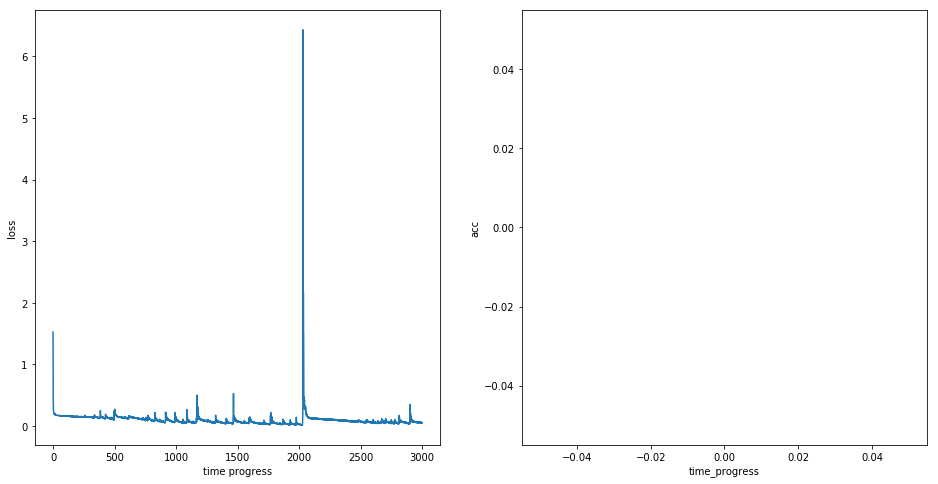

In [23]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('time progress')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('time_progress')
ax2.set_ylabel('acc')

In [24]:
Y_test_pred = ff_n.forward(X_test)

In [35]:
ff_n.eval()
print("Train set accuracy: ", accuracy(ff_n.forward(X_train), Y_OH_train), "\nValidation set accuracy: ", accuracy(ff_n.forward(X_val), Y_OH_val), "\nTest set accuracy: ", accuracy(ff_n.forward(X_test), Y_OH_test))

Train set accuracy:  0.9192459855713289 
Validation set accuracy:  0.9172774869109948 
Test set accuracy:  0.9460470085470085


# Visual Evaluation

[[1758    0    0    2    0]
 [   1  480    6    0    0]
 [   6   37   47    0    0]
 [   0    0    0    3    0]
 [   0    0    0    0  525]]


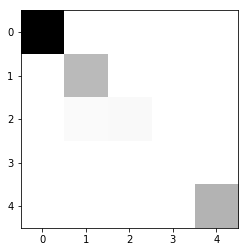

In [26]:
cm = confusion_matrix(np.argmax(Y_OH_val.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_val).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

[[2635    0    1    3    0]
 [   0  729    0    0    0]
 [   2  109   25    0    0]
 [   2    0    0    3    0]
 [   0    0    0    0  788]]


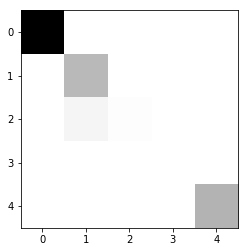

In [27]:
cm = confusion_matrix(np.argmax(Y_OH_train.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_train).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

[[1159    1    0    0    0]
 [  38  273    0    0    0]
 [  57    2    2    0    0]
 [   3    0    0    0    0]
 [   0    3    0    0  334]]


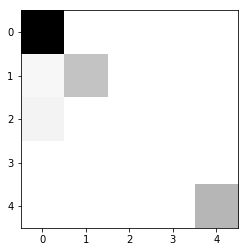

In [28]:
cm = confusion_matrix(np.argmax(Y_OH_test.to('cpu').detach().numpy(), 1), np.argmax(ff_n(X_test).to('cpu').detach().numpy(), 1))
print(cm)
plt.imshow(cm, cmap='binary')

# Saving Model

In [36]:
torch.save(ff_n.state_dict(), './weights')

In [37]:
model = FF_Network()
model.load_state_dict(torch.load('./weights'))
model.to(device)
# model.eval()

FF_Network(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=55, bias=True)
    (1): BatchNorm1d(55, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=55, out_features=40, bias=True)
    (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=5, bias=True)
  )
)

In [38]:
print("Train set accuracy: ", accuracy(model.forward(X_train), Y_OH_train), "\nValidation set accuracy: ", accuracy(model.forward(X_val), Y_OH_val), "\nTest set accuracy: ", accuracy(model.forward(X_test), Y_OH_test))

Train set accuracy:  0.9727717011868746 
Validation set accuracy:  0.9818499127399651 
Test set accuracy:  0.9444444444444444


In [39]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(np.argmax(Y_test_pred.to('cpu').detach().numpy(), 1))

Error: iterable expected, not numpy.int64

In [ ]:
np.argmax(Y_test_pred.to('cpu').detach().numpy(), 1)